# Introduction to Scientific Python - 2 #

Lecturer: Giuseppe Santoro

A follow up of the previous Notebook 1: it will teach us about **sparse matrices** and **quantum spin chains**.

We will see how to write python functions to diagonalise a **quantum Ising chain** without using any mapping to fermions. Obviously, you can only go up to relatively small chain lengths. But the approach is general enough that you can diagonalise spin-models that *do not allow* for a Jordan-Wigner fermionization.

### Importing the Scientific Environment ###

As previously discussed, the simplest way to use the basic scientific libraries (numpy, scipy) and plotting tools (matplotlib) in jupyter is to execute the following command at the beginning of your notebook:

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

A few comments:
1. **%matplotlib notebook** allows to manipulate images (zoom, etc). If you use **inline** (another *backend*, as it is called) instead of **notebook**, images are static. Unfortunately, this does not appear to work properly in Google Colab. My advice: download the notebook and run it on your desktop.

2. **scipy.sparse**, imported as sps, is the library for working with sparse-matrices.

# Sparse Matrices

Many matrices (local Hamiltonians, adjacency matrices, etc) are *sparse*. This means that most of the elements are 0. Let us examine this in more detail.

# Diagonalizing a quantum Ising Spin Chain #

Let's construct and find the spectrum of a L-site transverse field Ising chain. For the uniform case we would have:

$$ \hat{H} = - J \sum_{j=1}^L \hat{\sigma}^z_{j} \hat{\sigma}^z_{j+1} - h \sum_{j=1}^L \hat{\sigma}^x_j $$

The Pauli operators $\hat{\sigma}_j^{\alpha}$ are implicitly **tensor products** with the identity on other sites. 

How do we deal with this? **np.kron** and **sps.kron** are wonderful functions that do this for you! Here **kron** stands for Kroenecker, and it comes in two versions: 

- the **numpy** version, **np.kron**, working with ordinary dense np.array
- the **scipy** version, **sps.kron**, working with a sparse-matrix representation. 

Let me explain a bit more this *tensor product structure*. 

# Tensor products #

A **tensor product** of two ordinary vectors **u** (n-dimensional) and **v** (m-dimensional) is defined as the
$nm$-dimensional vector ${\bf u}\otimes {\bf v}$ whose components are:
$$
{\bf u}\otimes {\bf v} = \left( \begin{array}{c} u_1 {\bf v} \\ u_2 {\bf v} \\ \vdots \\ u_n {\bf v} \end{array} \right) = \left( \begin{array}{c} u_1 v_1 \\ \vdots \\ u_1 v_m \\ u_2 v_1 \\ \vdots \\ u_2 v_m \\ \vdots \\ u_n v_m \end{array} \right) \stackrel{{\scriptscriptstyle reshape}}{\Longrightarrow} 
\left( \begin{array}{cccc} u_1 v_1 & u_1 v_2 & \cdots & u_1 v_m \\
u_2 v_1 & u_2 v_2 & \cdots & u_2 v_m \\
\vdots & \vdots & \cdots & \vdots \\
u_n v_1 & u_n v_2 & \cdots & u_n v_m \end{array}
\right)\;. 
$$
Quite amusingly, it could also be regarded as an $n\times m$ **matrix** (by reshaping the $nm$-dimensional vector), with *peculiarly factorized* elements $({\bf u}\otimes {\bf v})_{ij} = u_i v_j$. Hence, by applying it to an $m$-dimensional vector ${\bf x}$ you would obtain $({\bf u}\otimes {\bf v}) \, {\bf x} = {\bf u} ({\bf v} \cdot {\bf x})$, as you can immediately verify. Observe that ${\bf v}$ acts as a *row vector* while ${\bf u}$ acts as a *column vector*. 

This application of tensor products of vectors is similar to the quantum-mechanical expression $|{\bf u}\rangle\langle {\bf v}|$, where one would apply it for $n=m$, observing that this is really $({\bf u}\otimes {\bf v}^*)$, because a *bra* comes with the star. 

Another way of looking at ${\bf u}\otimes {\bf v}$ is as two vectors living in the tensor product ${\mathbb C}^n \otimes {\mathbb C}^m$, which should not be confused with the Cartesian product ${\mathbb C}^n \times {\mathbb C}^m\equiv {\mathbb C}^{n+m}$, as it is rather isomorphic to ${\mathbb C}^{nm}$.  In such a case, the peculiar factorisation is, quantum mechanically, a signature of a *product* or *separable* state. 

It is useful to index two-component vectors with their index starting from $0$, for instance
$$ {\bf x} = \left( \begin{array}{c} x_0 \\ x_1 \end{array} \right) \;. $$
The same convention is actually useful also for higher dimensional vectors, and is indeed the standard convention that python uses in indexing its arrays: always start from 0, not 1. You will see this is very handy for binary conversion of integers. 

Obviously, you can tensor-multiply more than two vectors. For instance, if you multiply $3$ two-component vectors vectors ${\bf x}$, ${\bf y}$ and ${\bf z}$ you would obtain an $(8=2^3)$-component vector:
$$
\left( \begin{array}{c} x_0 \\ x_1 \end{array} \right) \otimes \left( \begin{array}{c} y_0 \\ y_1 \end{array} \right)
\otimes \left( \begin{array}{c} z_0 \\ z_1 \end{array} \right) = 
\left( \begin{array}{c} x_0 y_0 z_0 \\ x_0 y_0 z_1 \\ x_0 y_1 z_0 \\ x_0 y_1 z_1 \\ x_1 y_0 z_0 \\ x_1 y_0 z_1 \\ x_1 y_1 z_0 \\ x_1 y_1 z_1  \end{array} \right) \;,
$$
where you should observe that **the components of the vectors to the right advance before those of the vectors to the left**. Needless to say, the most general vector in ${\mathbb C}^8$ can be written as an arbitary combination of such *basis* vectors, and this is one of the potential advantage of Quantum Computing with respect to a classical computation.

**Interlude on classical bits and Qbits**. 
You can associate the two states $|0\rangle$ and $|1\rangle$ to the following two-component vectors:
$$ |0\rangle = \left(\begin{array}{c} 1 \\ 0 \end{array} \right) \hspace{20mm}  
|1\rangle = \left(\begin{array}{c} 0 \\ 1 \end{array} \right) \;.
$$
If you label the two components as $0$ and $1$, instead of $1$ and $2$, you notice that $|0\rangle$ has a $1$ in component 0, while $|1\rangle$ has a $1$ in component 1. The reason why this is much better than the reversed convention, and is indeed the **standard convention in the Quantum Information community** will be clear shortly. 

Suppose that you now consider the 3-Qbit state $|101\rangle=|1\rangle \otimes |0\rangle \otimes |1\rangle$,
where $\otimes$ denotes the *Hilbert space tensor product* and you apply the rule for the tensor product of the three ordinary two-component vectors representing the three states. You would get:
$$
|101\rangle=|1\rangle \otimes |0\rangle \otimes |1\rangle = \left( \begin{array}{c} 0 \\ 1 \end{array} \right) \otimes \left( \begin{array}{c} 1 \\ 0 \end{array} \right)\otimes \left( \begin{array}{c} 0 \\ 1 \end{array} \right) = \left( \begin{array}{c} 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\end{array} \right) \;.
$$
The $8$-component vector which results, with components numbered from 0 to 7, has a 1 in position 5, and the **binary representation** of 5 is precisely $101$. Notice that with the reversed convention on the Qbit assignement 
$$ |0\rangle \to |\!\downarrow\rangle = \left(\begin{array}{c} 0 \\ 1 \end{array} \right) \hspace{20mm}  
|1\rangle \to |\!\uparrow\rangle = \left(\begin{array}{c} 1 \\ 0 \end{array} \right) \;.
$$
this little miracle would be lost! Ultimately, the reason why the Quantum Information convention $|0\rangle=|\!\uparrow\rangle$ and $|1\rangle=|\!\downarrow\rangle$, in terms of ordinary spin-1/2 states, is that this convention preserves the standard ordering of basis elements in which you write the Pauli matrices, $\{|\!\uparrow\rangle,|\!\downarrow\rangle\}$, in close analogy with the obvious ordering of Qbit states $\{|0\rangle,|1\rangle\}$.

**Tensor products of matrices**. Similarly to vectors, you can consider the tensor product of two matrices (recall that matrices can be regarded as reshaped vectors containing the successive rows of the matrix, one after the other). Let us consider for simplicity of notation the case of **square matrices**. If ${\mathbb A}$ is an $n\times n$ matrix with elements $({\mathbb A})_{ij}=a_{ij}$ and ${\mathbb B}$ an $m\times m$ matrix with elements $({\mathbb B})_{kl}=b_{kl}$, then the tensor product of the two is defined by the following **block-matrix construction**:
$$
{\mathbb A} \otimes {\mathbb B} = 
\left( \begin{array}{cccc} a_{11} {\mathbb B} & a_{12} {\mathbb B} & \cdots & a_{1n} {\mathbb B} \\
a_{21} {\mathbb B} & a_{22} {\mathbb B} & \cdots & a_{2n} {\mathbb B} \\
\vdots & \vdots & \cdots & \vdots \\
a_{n1} {\mathbb B} & a_{n2} {\mathbb B} & \cdots & a_{nn} {\mathbb B} \end{array}
\right) \;.
$$
Observe that, consistently, the matrix elements are $({\mathbb A} \otimes {\mathbb B})_{ij,kl} = a_{ij} b_{kl}$. 

If you think of acting with such a *separable matrix* on a *separable vector* given by ${\bf x}\otimes {\bf y}\in {\mathbb C}^n \otimes {\mathbb C}^m$ you would get a separable vector where *each matrix acts independently on its own vector*:
$$
({\mathbb A} \otimes {\mathbb B}) \; ({\bf x}\otimes {\bf y}) = ({\mathbb A} {\bf x} ) \otimes ( {\mathbb B} {\bf y})
$$
Now we are ready to proceed with our spin-chain problem.

# Pauli matrices in dense form #

We use *np.eye(n)* to create an n-dimensional **identity matrix**.
We also use:
$$
\hat{\sigma}^y = -i \hat{\sigma}^z \hat{\sigma}^x
$$

In [2]:
# Defines the 2x2 Pauli matrices in dense form
# np.eye(2) creates the 2-dimensional identity matrix
# Notice the @ to calculate the matrix product of Sz and Sx, which gives Sy by multiplication by -i

Id = np.eye(2)
Sx = np.array([[0.,1.],[1.,0.]])
Sz = np.array([[1.,0.],[0.,-1]])
Sy = -1j * Sz@Sx

In [3]:
Sy

array([[0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j]])

Now I use **np.kron** to calculate
$$ \hat{\sigma}^x_1 \otimes \mathbb{1}_2 $$
on the Hilbert space of the first two spins

In [4]:
np.kron(Sx,Id) 

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

Iterate **np.kron** to calculate for instance:
$$ \hat{\sigma}^x_1 \otimes \mathbb{1}_2 \otimes \mathbb{1}_3 $$
on the Hilbert space of the first three spins.

In [5]:
np.kron(np.kron(Sx,Id), Id)

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

# Pauli matrices (and tensor products) in sparse form #

Now, we do the same using **sparse matrix representations**.
Many different sparse matrix formats are supported by scipy. 

Later on, it will be useful to adopt the **dok_matrix** form:

class scipy.sparse.dok_matrix(arg1, shape=None, dtype=None, copy=False)

which is a dictionary of keys based sparse matrix. 
This is an efficient structure for constructing sparse matrices incrementally.
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html

In particular: 

- dok_matrix.setdiag(values, k)

sets the off-diagonal values (i,i+k) (default is k=0, the main diagonal).

So, for instance, we can first set the shape and type of a matrix A to LxL and float32

-  A = sps.dok_matrix((L,L),dtype=np.float32)

and then set the diagonal by:

- A.setdiag(array_of_diagonal_values)  

The diagonal **above** the main diagonal is set by:

- A.setdiag(array_of_values, k = 1)

For the time being, we will use the **compressed sparse row** form:

Compressed sparse row (CSR)
  - Stores non-zero entries in each row contiguously
  - Fast matrix-vector multiply
  - Primary format for most math operations

The a.toarray() function transforms the sparse matrix a into np.array form.


In [6]:
Ids = sps.eye(2)
Sxs = sps.csr_matrix(np.array([[0,1.],[1,0]]))
Szs = sps.csr_matrix(np.array([[1,0.],[0,-1]]))
Sys = -1j * Szs @ Sxs

In [7]:
# Observe the two outputs. In sparse form:
Sxs

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [8]:
# In array form:
Sxs.toarray()

array([[0., 1.],
       [1., 0.]])

Again we iterate (now) **sps.kron** to calculate for instance:
$$ \hat{\sigma}^x_1 \otimes \mathbb{1}_2 \otimes \mathbb{1}_3 $$
on the Hilbert space of the first three spins.

In [9]:
Sx0in3 = sps.kron(sps.kron(Sxs,Ids),Ids)
# We show directly the array form:
Sx0in3.toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

## Towards making things simpler: using FOR with an operator list ##

Now we do a similar thing but with a FOR loop on the elements of an **operator list** opList

In [10]:
opList = [Sxs,Ids,Ids]

In [11]:
opList

[<2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements (1 diagonals) in DIAgonal format>,
 <2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements (1 diagonals) in DIAgonal format>]

In [12]:
# We start from the [0] element, and we kron-multiply to the right by the other operators in the list
Sx0 = opList[0]

for op in opList[1:]:
    Sx0 = sps.kron(Sx0, op)

In [13]:
# Here is the final result:
Sx0.toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

## Functional programming tricks ##

Once can use *functools.reduce* to avoid FOR loops with a functional programming technique.

Very briefly, suppose you have a *pure* two-argument function like:

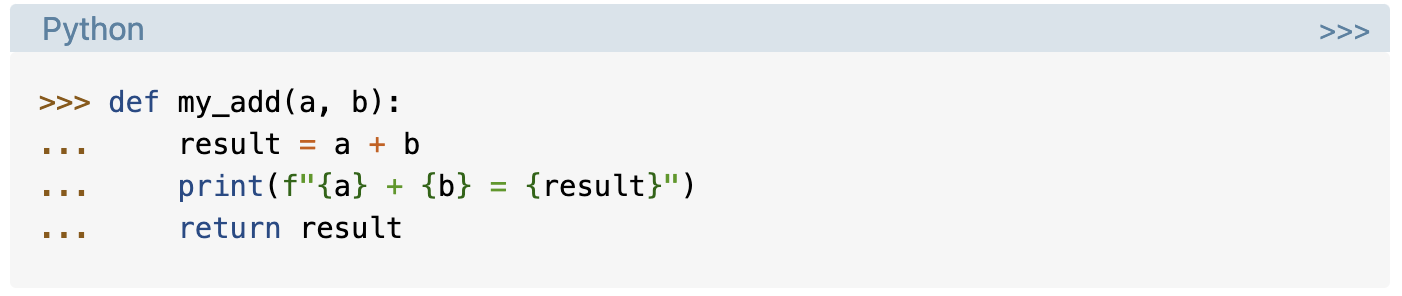

which does the sum of two numbers without changing any other variable in the code:

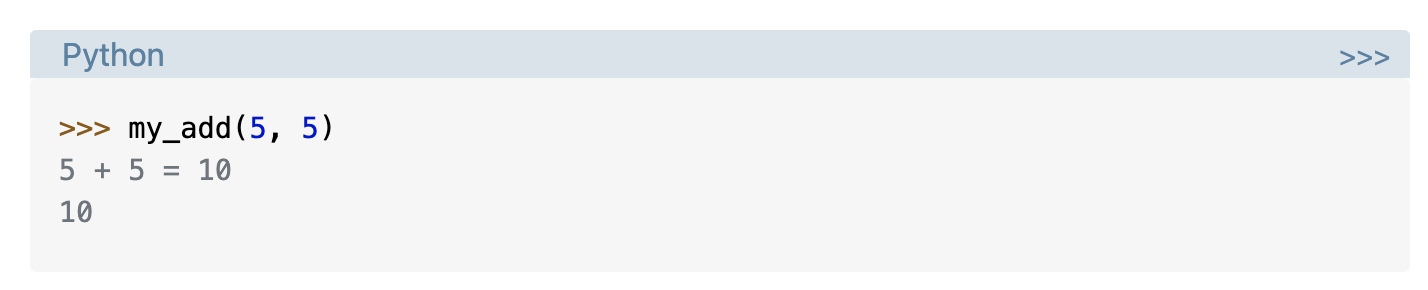

Then, look at what reduce() does. It iterates the function by applying it to an iterable (list):

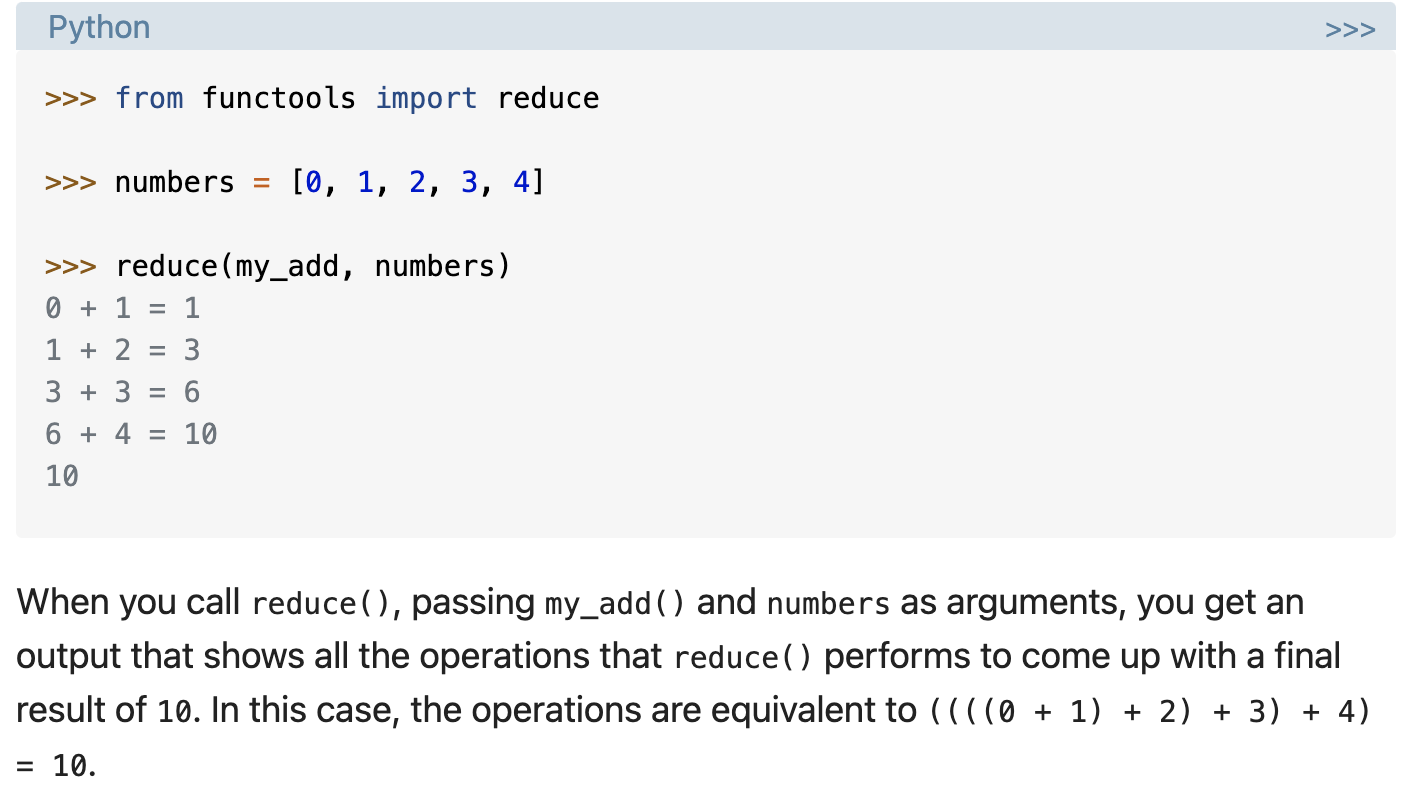

An excellent tutorial to learn more about the use of reduce() is: https://realpython.com/python-reduce-function/

Here is how to iterate **sps.kron**, our two-argument function, over the opList of operators, to produce the operator you need in one shot:

In [14]:
from functools import reduce
Sx0 = reduce(sps.kron, opList)
Sx0.toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

# Building the Hamiltonian, diagonalising it, and testing execution times #
Now we will learn how to write the Hamiltonian matrix, to diagonalise it, testing how long it takes.

### Defining the Hamiltonian matrix for the transverse field Ising model ###

Recall that:

$$ \hat{H} = - J \sum_{j=1}^L \hat{\sigma}^z_j \hat{\sigma}^z_{j+1} - h \sum_{j=1}^L \hat{\sigma}^x_j $$

We use the *reduce* functional trick and *sps.kron* to perform tensor products of sparse Pauli/identiy matrices.

First we do things **by hand** for $L=3$. 


In [15]:
# For L=3 the two terms of the Hamiltonian would read:
# Here is the transverse field part
HField = reduce(sps.kron, [Sxs, Ids, Ids]) + \
    reduce(sps.kron, [Ids, Sxs, Ids]) + \
    reduce(sps.kron, [Ids, Ids, Sxs])
# Still for L=3 (with PBC), here is the zz-interaction
HBond = reduce(sps.kron, [Szs, Szs, Ids]) + \
    reduce(sps.kron, [Ids, Szs, Szs]) + \
    reduce(sps.kron, [Szs, Ids, Szs])

In [16]:
# Now I set the (uniform) couplings and define a sparse Hamiltonian Ham, and its dense form, with .toarray()
J = 1.
h = 0.5
Ham = -J * HBond - h * HField
HamDense = Ham.toarray()

In [17]:
HamDense

array([[-3. , -0.5, -0.5,  0. , -0.5,  0. ,  0. ,  0. ],
       [-0.5,  1. ,  0. , -0.5,  0. , -0.5,  0. ,  0. ],
       [-0.5,  0. ,  1. , -0.5,  0. ,  0. , -0.5,  0. ],
       [ 0. , -0.5, -0.5,  1. ,  0. ,  0. ,  0. , -0.5],
       [-0.5,  0. ,  0. ,  0. ,  1. , -0.5, -0.5,  0. ],
       [ 0. , -0.5,  0. ,  0. , -0.5,  1. ,  0. , -0.5],
       [ 0. ,  0. , -0.5,  0. , -0.5,  0. ,  1. , -0.5],
       [ 0. ,  0. ,  0. , -0.5,  0. , -0.5, -0.5, -3. ]])

### Diagonalisation of the Hamiltonian (as a dense matrix) ###

Two main methods are used, depending on whether you want only the **eigenvalues** (use *np.linalg.eigvalsh*) or **eigenvalues and eigenvectors** (use *np.linalg.eigh*).


In [18]:
# This is the method to calculated the eigenvalues only of a matrix in dense form. 
# The eigenvalues are put in a array called e
e = np.linalg.eigvalsh(HamDense)

In [19]:
e

array([-3.23205081, -3.14575131,  0.23205081,  0.5       ,  0.5       ,
        1.5       ,  1.5       ,  2.14575131])

In [22]:
# Here is the way to time how much it takes to calculate the eigenvalues only
%timeit np.linalg.eigvalsh(HamDense)

9.5 µs ± 244 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
# Here we see the method to calculate both eigenvalues e and eigenvectors u
(e,u) = np.linalg.eigh(HamDense)

In [24]:
# Time to get both eigenvalues e and eigenvectors u
%timeit np.linalg.eigh(HamDense)

16.8 µs ± 589 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Plotting the spectrum of the transverse field Ising model vs h #

Let's make a plot of the spectrum as a function of swept transverse field $h$. 
Recall that in the thermodynamic limit, there's a quantum phase transition at $h = J (=1)$.

The **np.r_** trick for making arrays is explained in

https://numpy.org/doc/stable/reference/generated/numpy.r_.html

Very quickly:

np.r_[start:stop:step] is equivalent to np.arange(start, stop, step) inside of the brackets. 

However, if step is an imaginary number (i.e. 100j) then its integer portion is interpreted as a number-of-points desired and the start and stop are inclusive. 
In other words: 

np.r_[start:stop:stepj]

is interpreted as: 

np.linspace(start, stop, step, endpoint=1) 

inside of the brackets. 

In [25]:
# Here is a quick way of making an array of transverse field values.
# Notice the j-trick in the third (step) argument, as if it was an imaginary number.
# It is used if you want, rather than a step increment, 41 points between 0 and 4 including the extrema
Hs = np.r_[0:4:41j]

In [30]:
# To list the various transverse fields:
# Hs
list(enumerate(Hs))

[(0, 0.0),
 (1, 0.1),
 (2, 0.2),
 (3, 0.30000000000000004),
 (4, 0.4),
 (5, 0.5),
 (6, 0.6000000000000001),
 (7, 0.7000000000000001),
 (8, 0.8),
 (9, 0.9),
 (10, 1.0),
 (11, 1.1),
 (12, 1.2000000000000002),
 (13, 1.3),
 (14, 1.4000000000000001),
 (15, 1.5),
 (16, 1.6),
 (17, 1.7000000000000002),
 (18, 1.8),
 (19, 1.9000000000000001),
 (20, 2.0),
 (21, 2.1),
 (22, 2.2),
 (23, 2.3000000000000003),
 (24, 2.4000000000000004),
 (25, 2.5),
 (26, 2.6),
 (27, 2.7),
 (28, 2.8000000000000003),
 (29, 2.9000000000000004),
 (30, 3.0),
 (31, 3.1),
 (32, 3.2),
 (33, 3.3000000000000003),
 (34, 3.4000000000000004),
 (35, 3.5),
 (36, 3.6),
 (37, 3.7),
 (38, 3.8000000000000003),
 (39, 3.9000000000000004),
 (40, 4.0)]

In [31]:
# Similar, using a step, but now the last point is missing
np.r_[0:4:0.1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9])

## Putting things together ##

In [35]:
# We set the couplings:
J = 1.
Hs = np.r_[0:4:41j]

# A matrix ens array is created, with as many column as the Hilbert space, and initially put to zero
ens = np.zeros((len(Hs), 2**3), dtype=float)

# We loop over the transverse field and diagonalise. Notice the useful enumerate, so that the index is known:
for (i,h) in enumerate(Hs):
    Ham = -J * HBond - h * HField
    ens[i] = np.linalg.eigvalsh(Ham.toarray())


<IPython.core.display.Javascript object>


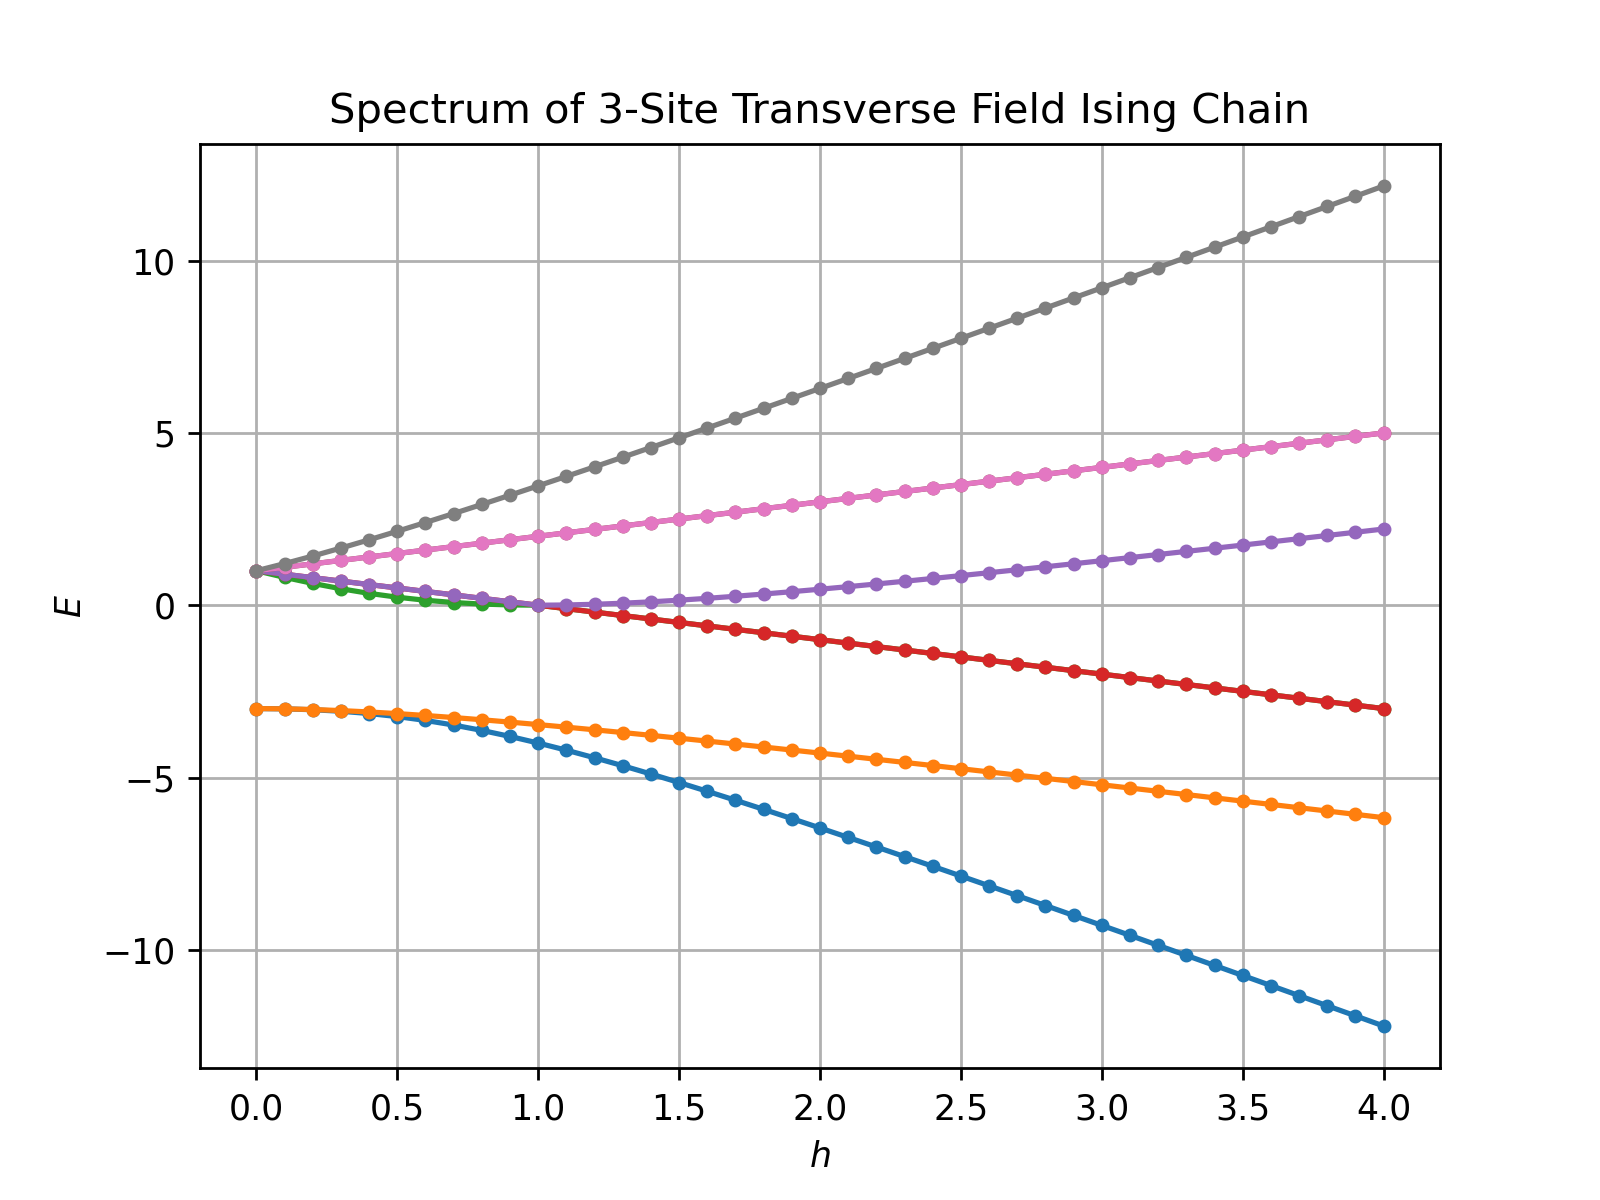

Text(0, 0.5, '$E$')

In [36]:
# A plot of the spectrum vs the transverse field is created
plt.figure()
plt.plot(Hs, ens, '.-')
plt.title(r'Spectrum of 3-Site Transverse Field Ising Chain')
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')

# Writing functions to get sparse matrix representations of $\hat{\sigma}^x_j$ and $\hat{\sigma}^z_{j} \hat{\sigma}^z_{j+1}$ #

It would be nice to be able to do all such things automatically for a larger values of L, with L an **input**. For that purpose, we need to construct sparse representation of interesting operators more generally. As a tool, we create OpList which have now L elements, with the correct operators in the proper place. One starts with a list containing only the identities:

In [37]:
n = 7
OpList = [Ids for x in range(n)]

In [40]:
OpList[0].toarray()

array([[1., 0.],
       [0., 1.]])

Then, the operator needed, for instance Sx, is added at the right place in the OpList. 

Here is a function that does that, with L in input and the site j=0..L-1 also as input.

In [41]:
def makeSx(j,L):
    """Return Sxj, the sparse matrix representation of Pauli-x at site j=0..L-1 in a chain of L sites"""
    Ids = sps.eye(2)
    Sxs = sps.csr_matrix(np.array([[0.,1.],[1.,0.]]))
    OpList = [Ids for x in range(L)]
    if ((j>=0) and (j<L)):
        OpList[j] = Sxs
    else:
        print("Wrong j = " + str(j))
    from functools import reduce
    Sxj = reduce(sps.kron, OpList)
    return Sxj

In [45]:
# Let us test that the usual Sx on site 0 is well reproduced for L=3
Sxj=makeSx(0,4)
Sxj.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

Now we play a similar trick to put the appropriate pair of Sz on two **neighboring sites** of OpList, including the possibility of a PBC link connecting the last site to the first. The function makeSzSz does that.

In [49]:
def makeSzSz(j,L):
    """Return SzSzj, the sparse matrix representation of two Pauli-z at site (j=0..L-1,j+1) in a chain of L sites"""
    Ids = sps.eye(2)
    Szs = sps.csr_matrix(np.array([[1.,0.],[0.,-1.]]))
    OpList = [Ids for x in range(L)]
    if ((j>=0) and (j<L-1)):
        OpList[j] = Szs
        OpList[j+1] = Szs
    elif (j==L-1):
        OpList[-1] = Szs
        OpList[0] = Szs
    else:
        print("Wrong j = " + str(j))
    from functools import reduce
    SzSzj = reduce(sps.kron, OpList)
    return SzSzj

In [50]:
# Let us test that the usual Sx on site 0 is well reproduced for L=3
Szj=makeSzSz(0,4)
Szj.toarray()

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

### Now we construct functions that construct the sparse Hamiltonian with a for loop ###

In [ ]:
def makeHbond(L,PBC):
    """Return the sum of SzSzj for j=0..L-1 in a chain of L sites with a PBC Boolean flag"""
    Hbond = makeSzSz(0,L)
    for j in range(L-2):
        Hbond += makeSzSz(j+1,L)
    if (PBC==True):
        Hbond += makeSzSz(L-1,L)
    return Hbond

In [ ]:
def makeHfield(L):
    """Return the sum of Sxj for j=0..L-1 in a chain of L sites"""
    Hfield = makeSx(0,L)
    for j in range(L-1):
        Hfield += makeSx(j+1,L)
    return Hfield

### Finally, we do a spectrum for a value of L that we can select as we wish. ###
Carefull: time (and memory) is an issue. Do not overdo with L, as the problem Hilbert space scales as $2^L$.
Try, if needed, some timing.

In [ ]:
L=12
J = 1.
Hs = np.r_[0:4:41j]
# We choose True or False for the PBC flag
Hbond = makeHbond(L,True)
Hfield = makeHfield(L)

# A matrix array ens is created, with as many column as the Hilbert space, and initially put to zero
ens = np.zeros((len(Hs), 2**L), dtype=float)

for (i,h) in enumerate(Hs):
    Ham = -J * Hbond - h * Hfield
    ens[i] = np.linalg.eigvalsh(Ham.toarray())


<IPython.core.display.Javascript object>


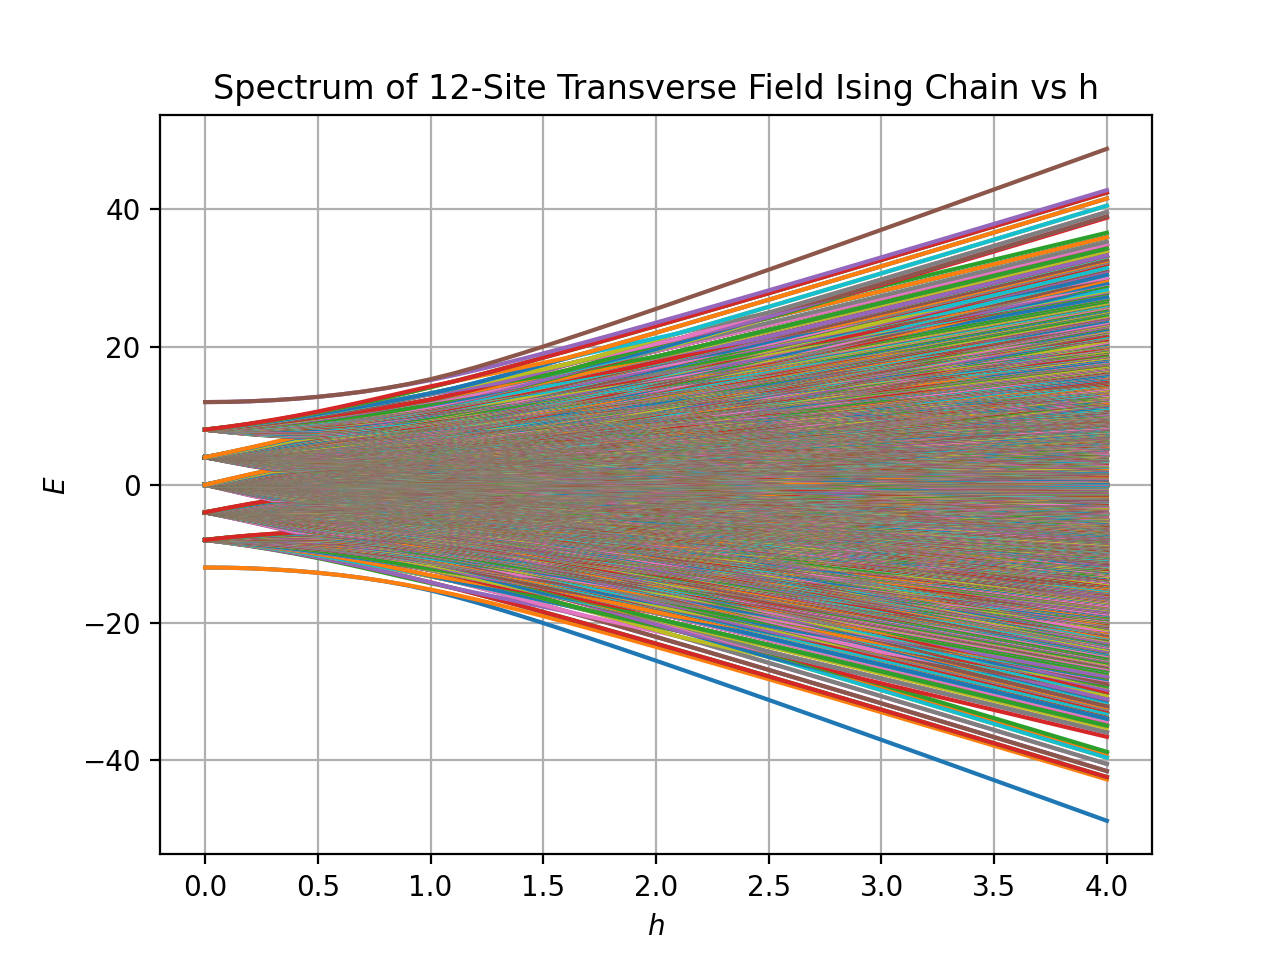

Text(0, 0.5, '$E$')

In [ ]:
# We plot the spectrum. 
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs h')
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')

## Adding longitudinal fields ##

We need also single $\hat{\sigma}_j^z$ and longitudinal field Hamiltonian terms. 


In [ ]:
def makeSz(j,L):
    """Return Szj, the sparse matrix representation of Pauli-x at site j=0..L-1 in a chain of L sites"""
    Ids = sps.eye(2)
    Szs = sps.csr_matrix(np.array([[1.,0],[0,-1.]]))
    OpList = [Ids for x in range(L)]
    if ((j>=0) and (j<L)):
        OpList[j] = Szs
    else:
        print("Wrong j = " + str(j))
    from functools import reduce
    Szj = reduce(sps.kron, OpList)
    return Szj

In [ ]:
def makeHfieldz(L):
    """Return the sum of Szj for j=0..L-1 in a chain of L sites"""
    Hfieldz = makeSz(0,L)
    for j in range(L-1):
        Hfieldz += makeSz(j+1,L)
    return Hfieldz

In [ ]:
L=4
J = 1.
hperp=0.9
Hs = np.r_[0:2:401j]
# We choose True or False for the PBC flag
Hbond = makeHbond(L,True)
Hfield = makeHfield(L)
Hfieldz = makeHfieldz(L)

# A matrix array ens is created, with as many column as the Hilbert space, and initially put to zero
ens = np.zeros((len(Hs), 2**L), dtype=float)

for (i,h) in enumerate(Hs):
    Ham = -J * Hbond - h * Hfieldz - hperp * Hfield
    ens[i] = np.linalg.eigvalsh(Ham.toarray())

<IPython.core.display.Javascript object>


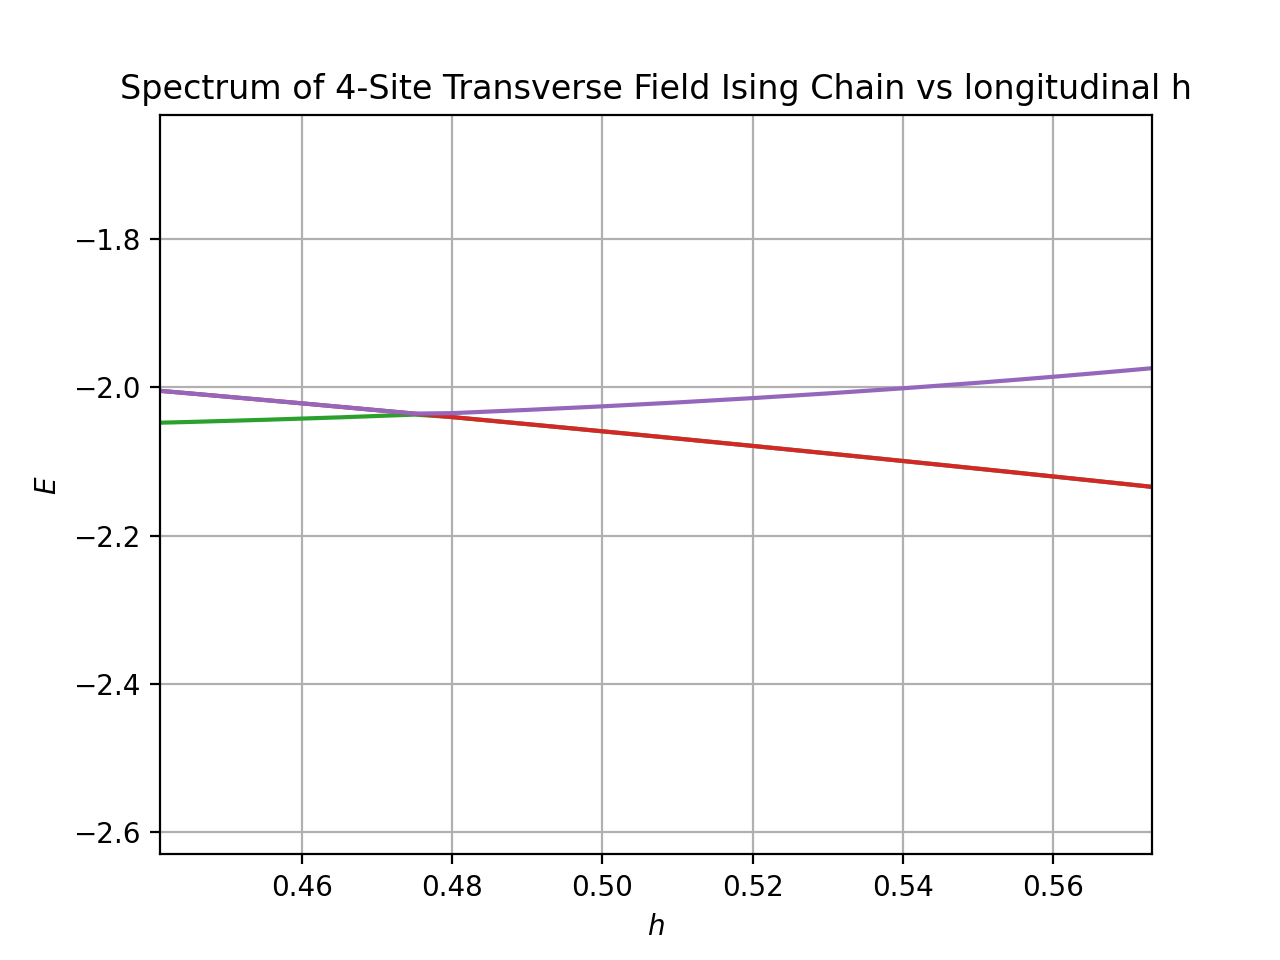

Text(0, 0.5, '$E$')

In [ ]:
# We plot the spectrum. 
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs longitudinal h')
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')

# Exercise 1: The disordered Ising chain #

Generalise the previous calculations to the case of a general quantum Ising chain:

$$ \hat{H} = - \sum_{j=1}^L J_j \hat{\sigma}^z_j \hat{\sigma}^z_{j+1} -\sum_{j=1}^L h_j \hat{\sigma}^x_j $$

with general couplings $J_j$ and transverse fields $h_j$ (you can restrict both to be non-negative, for instance $J_i\in (0,1)$ and $h_j\in (0,h)$). Treat both the case of PBC and that of OBC (for instance putting $J_L=0$).

**Hint:** Construct a function **makeHam(J,h)** that gives the Hamiltonian in sparse form, with input the couplings J and h, appropriately exploiting the two functions **makeSzSz** and **makeSx**


# Exercise 2: The Heisenberg XXZ chain #

Setup all the necessary functions to diagonalise the XXZ Heisenberg chain:

$$ \hat{H} = J \sum_{j=1}^L \left( \hat{\sigma}^x_j \hat{\sigma}^x_{j+1} + \hat{\sigma}^y_j \hat{\sigma}^y_{j+1} + \Delta \hat{\sigma}^z_j \hat{\sigma}^z_{j+1}\right) $$

Treat both the case of PBC and that of OBC (for instance putting $J_L=0$).